In [1]:
# Core libraries
import pandas as pd

# Hugging Face Transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# PyTorch
import torch

# Scikit-learn for evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Matplotlib for plotting
import matplotlib.pyplot as plt

In [2]:
# Load test data
test_data = pd.read_pickle("../data/processed_test.pkl")
test_data = test_data.sample(frac=0.1, random_state=42) # Use only 10% of the data

# Map labels to integers
label_map = {"negative": 0, "positive": 1}
test_data['sentiment'] = test_data['sentiment'].map(label_map)

# Load tokenizer and tokenize all at once
tokenizer = AutoTokenizer.from_pretrained("../models/distilbert_fine_tuned")
tokens = tokenizer(
    test_data['review'].tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt",
)

# Move labels to tensors
labels = torch.tensor(test_data['sentiment'].tolist())


In [3]:
# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("../models/distilbert_fine_tuned")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Perform predictions in batches
BATCH_SIZE = 16
all_preds = []  # Predicted labels
true_labels = labels.numpy()  # Ground truth labels

for i in range(0, len(tokens['input_ids']), BATCH_SIZE):
    batch_inputs = {key: val[i:i+BATCH_SIZE].to(device) for key, val in tokens.items()}
    with torch.no_grad():
        outputs = model(**batch_inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        all_preds.extend(predictions.cpu().numpy())  # Store predictions


In [4]:
# Calculate metrics
precision = precision_score(true_labels, all_preds)
recall = recall_score(true_labels, all_preds)
f1 = f1_score(true_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 0.9511
Recall: 0.9522
F1-Score: 0.9517


In [5]:
# Add predictions to the test dataset
test_data['predicted'] = all_preds

# Identify misclassified examples
misclassified = test_data[test_data['sentiment'] != test_data['predicted']]
print("Misclassified Examples:")
print(misclassified[['review', 'sentiment', 'predicted']].head())


Misclassified Examples:
                                                   review  sentiment  \
323107  canera case Great sturdy case for my sony came...          0   
186689  STColeridge NOT TSEliot Excellent selection of...          1   
113867  Caution on included batteries I purchased six ...          1   
353939  What an awesome DVD this could have been if Ge...          0   
219081  Dont be fooled Rewritten and expanded my left ...          0   

        predicted  
323107          1  
186689          0  
113867          0  
353939          1  
219081          1  


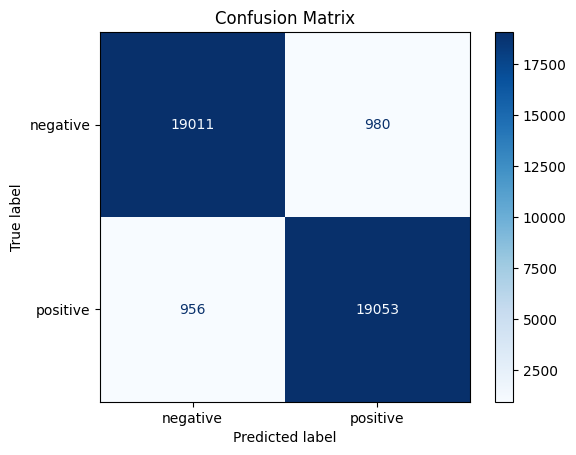

In [6]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, all_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
